# Abstract
This notebook used postgres sql and pyspark to create a Spotify Music Recommendation by using different classification method

# I. Basic Setup

In [1]:
from pyspark.sql import SparkSession
from os.path import abspath
import findspark
from pyspark.sql.functions import mean, sum, to_date, hour, when, date_format, count, isnan, col, weekofyear
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.ml.recommendation import ALS
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.regression import RandomForestRegressor

In [2]:
# Set the Config dictionary used to connected to postgres sql
config = {
    'postgres': {'driver': 'org.postgresql.Driver',
                 'password': 'project',
                 'url': 'jdbc:postgresql://localhost:5432/project',
                 'user': 'tony'},
    'spark': {'spark_jars': 'spark.jars',
              'spark_jars_path': '/home/cis6180/wd/jars/postgresql-42.5.1.jar',
              'spark_master': 'spark://cis6180.myguest.virtualbox.org:7077'},
    'stream_config': {'host': 'rtd.hpwren.ucsd.edu', 'port': 12028},
    'mongo': {'host': 'localhost', 'port': 27017}
}

In [3]:
findspark.init()
spark = SparkSession \
    .builder \
    .master(config['spark']['spark_master']) \
    .appName("project") \
    .enableHiveSupport() \
    .config('spark.sql.warehouse.dir', abspath('spark-warehouse')) \
    .config('spark.cores.max', '3') \
    .config('spark.excutor.cores', '3') \
    .config(config['spark']['spark_jars'], config['spark']['spark_jars_path']) \
    .getOrCreate()

spark.sparkContext.setLogLevel('WARN')
spark

23/04/08 08:14:12 WARN Utils: Your hostname, cis6180 resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
23/04/08 08:14:12 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
23/04/08 08:14:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


## Section 1:Load and Display the Data

For my project, I just used the data download from the Kaggle. In total, there are 3 different types of data, and in this section, I just import all the data and print out some basic summary information for our data.

In [4]:
def read_df(name):
    df = (spark.read
    .format('jdbc')
    .option('url', config['postgres']['url'])
    .option('driver', config['postgres']['driver'])
    .option('user', config['postgres']['user'])
    .option('password', config['postgres']['password'])
    .option('dbtable', name)
    .load()
           )
    return df

In [5]:
music_df = read_df('music')
cust_df = read_df('cust')
tracks_df = read_df('tracks')

In this section, we just do some basic summary information about the music data. And we found out there are 1345 different trackers, there are 438 distinct artist for all the trackers, and the average length of those tracks are around 241

In [6]:
music_df.show(10)

+-------+--------------------+------------+------+
|trackid|               title|      artist|length|
+-------+--------------------+------------+------+
|      0|    Caught Up In You| .38 Special|   200|
|      1|        Fantasy Girl| .38 Special|   219|
|      2|     Hold On Loosely| .38 Special|   253|
|      3|Hold On Loosely  ...| .38 Special|   154|
|      4|   Art For Arts Sake|        10cc|   341|
|      5|          Kryptonite|3 Doors Down|   221|
|      6|               Loser|3 Doors Down|   127|
|      7|          Take On Me|        a-ha|   135|
|      8|       Back In Black|       AC/DC|   304|
|      9|             Big Gun|       AC/DC|   305|
+-------+--------------------+------------+------+
only showing top 10 rows



In [8]:
track_count = music_df.count()
track_distinct_count = music_df.select('trackid').distinct().count()
artist_distinct_count = music_df.select('artist').distinct().count()
avg_length = music_df.agg(mean('length')).collect()[0][0]

print('--'*11, "Summary  Table", "--"*11)
print('--'*30)
print("Total tracks: ", track_count)
print("Distinct total tracks: ", track_distinct_count)
print("Distinct total artist: ", artist_distinct_count)
print("Average length: ", avg_length)
print('--'*30)

---------------------- Summary  Table ----------------------
------------------------------------------------------------
Total tracks:  1345
Distinct total tracks:  1345
Distinct total artist:  438
Average length:  241.15315985130113
------------------------------------------------------------


Then, we also print out some basic summary information for the second table, we have 5000 distinct total customers, we have 2016 female customers, and 2984 male customers.

In [9]:
cust_df.show(10)

+------+----------------+------+--------------------+-----+----------+------+-----+--------+--------------+
|custid|            name|gender|             address|  zip|  signdate|status|level|campaign|linkedwithapps|
+------+----------------+------+--------------------+-----+----------+------+-----+--------+--------------+
|     0|   Gregory Koval|     0|13004 Easy Cider ...|72132|2013-06-04|     1|    1|       1|             0|
|     1|   Robert Gordon|     0|10497 Thunder Hic...|17307|2013-07-27|     1|    1|       1|             0|
|     2|   Paula Peltier|     0|10084 Easy Gate Bend|66216|2013-01-13|     1|    0|       4|             1|
|     3|   Francine Gray|     0|54845 Bent Pony H...|36690|2013-07-11|     1|    1|       1|             1|
|     4|    David Garcia|     0|8551 Tawny Fox Villa|61377|2012-09-09|     1|    0|       1|             1|
|     5|   Matthew Perry|     1|29677 Sunny Autum...|20115|2012-10-09|     1|    0|       3|             0|
|     6|Marjorie Jackman|   

In [10]:
cust_count = cust_df.count()
cust_distinct_count = cust_df.select('custid').distinct().count()
female_count = cust_df.agg(sum('gender')).collect()[0][0]
male_count = cust_distinct_count - female_count

print('--'*11, "Summary  Table", "--"*11)
print('--'*30)
print("Total customer: ", cust_count)
print("Distinct total customer: ", cust_distinct_count)
print("Total female number: ", female_count)
print("Total male number: ", male_count)
print('--'*30)

---------------------- Summary  Table ----------------------
------------------------------------------------------------
Total customer:  5000
Distinct total customer:  5000
Total female number:  2016
Total male number:  2984
------------------------------------------------------------


In [11]:
tracks_df.show(10)

+-------+------+-------+-------------------+------+-------+
|eventid|custid|trackid|           datetime|mobile|zipcode|
+-------+------+-------+-------------------+------+-------+
|      0|    48|    453|2014-10-23 03:26:00|     0|  72132|
|      1|  1081|     19|2014-10-15 18:32:00|     1|  17307|
|      2|   532|     36|2014-12-10 15:33:00|     1|  66216|
|      3|  2641|    822|2014-10-20 02:24:00|     1|  36690|
|      4|  2251|    338|2014-11-18 07:16:00|     1|  61377|
|      5|  1811|      6|2014-11-18 02:00:00|     1|  20115|
|      6|  3644|     24|2014-12-12 15:24:00|     1|  15330|
|      7|   250|    726|2014-10-07 09:48:00|     0|  33570|
|      8|  1782|    442|2014-12-30 15:27:00|     1|  41240|
|      9|  2932|    775|2014-11-12 07:45:00|     0|  63565|
+-------+------+-------+-------------------+------+-------+
only showing top 10 rows



In [12]:
event_count = tracks_df.count()
event_distinct_count = tracks_df.select('eventid').distinct().count()
tracks_custid_distinct_count = tracks_df.select('custid').distinct().count()
tracks_trackid_distinct_count = tracks_df.select('trackid').distinct().count()
non_mobile_count = tracks_df.agg(sum('mobile')).collect()[0][0]
mobile_count = event_count - non_mobile_count

print('--'*11, "Summary  Table", "--"*11)
print('--'*30)
print("Total event: ", event_count)
print("Distinct total event: ", event_distinct_count)
print("Distinct custid: ", tracks_custid_distinct_count)
print("Distinct trackid: ", tracks_trackid_distinct_count)
print("Total mobile number: ", mobile_count)
print("Total non mobile number: ", non_mobile_count)
print('--'*30)

---------------------- Summary  Table ----------------------
------------------------------------------------------------
Total event:  1000000
Distinct total event:  1000000
Distinct custid:  5000
Distinct trackid:  1700
Total mobile number:  392235
Total non mobile number:  607765
------------------------------------------------------------


## Section 2: Exploration Data Analysis

Cause we find out that there are some relationships between three tables. Then I merge three tables and try to create some useful information based on the information we have right now!

### Section 2-1 Data Visualization

In [10]:
track_cust_joined = tracks_df.join(cust_df, ['custid'], "left_outer")
track_cust_joined.show(5)

+------+-------+-------+-------------------+------+-------+---------------+------+--------------------+-----+----------+------+-----+--------+--------------+
|custid|eventid|trackid|           datetime|mobile|zipcode|           name|gender|             address|  zip|  signdate|status|level|campaign|linkedwithapps|
+------+-------+-------+-------------------+------+-------+---------------+------+--------------------+-----+----------+------+-----+--------+--------------+
|    48|      0|    453|2014-10-23 03:26:00|     0|  72132|   Lucas Pizano|     0|2723 Stony Beaver...|99256|2012-11-02|     1|    0|       3|             1|
|  1811|      5|      6|2014-11-18 02:00:00|     1|  20115|   Joshua Reyna|     0|987 Cotton Maple ...|24574|2013-01-14|     1|    1|       1|             1|
|   532|      2|     36|2014-12-10 15:33:00|     1|  66216|    Carlos Kirk|     0|14 Hidden Bear Ci...|90745|2013-07-14|     0|    2|       1|             1|
|  1081|      1|     19|2014-10-15 18:32:00|     1| 

In [11]:
all_join = track_cust_joined.join(music_df, ['trackid'], 'left_outer')
all_join.show(5)

+-------+------+-------+-------------------+------+-------+---------------+------+--------------------+-----+----------+------+-----+--------+--------------+-------------------+--------------------+------+
|trackid|custid|eventid|           datetime|mobile|zipcode|           name|gender|             address|  zip|  signdate|status|level|campaign|linkedwithapps|              title|              artist|length|
+-------+------+-------+-------------------+------+-------+---------------+------+--------------------+-----+----------+------+-----+--------+--------------+-------------------+--------------------+------+
|    453|    48|      0|2014-10-23 03:26:00|     0|  72132|   Lucas Pizano|     0|2723 Stony Beaver...|99256|2012-11-02|     1|    0|       3|             1|      Strange Magic|Electric Light Or...|   170|
|      6|  1811|      5|2014-11-18 02:00:00|     1|  20115|   Joshua Reyna|     0|987 Cotton Maple ...|24574|2013-01-14|     1|    1|       1|             1|              Loser

In [12]:
# Calaulate the how many tracks that each person listened
all_join.createOrReplaceTempView('all_join')
result = spark.sql("SELECT custid, name, COUNT(DISTINCT trackid)\
                   as numTracks FROM all_join GROUP BY custid,name ORDER BY numTracks DESC")

result.show(5)

+------+-------------+---------+
|custid|         name|numTracks|
+------+-------------+---------+
|     0|Gregory Koval|     1617|
|     1|Robert Gordon|     1510|
|     2|Paula Peltier|     1408|
|     3|Francine Gray|     1310|
|     4| David Garcia|     1306|
+------+-------------+---------+
only showing top 5 rows



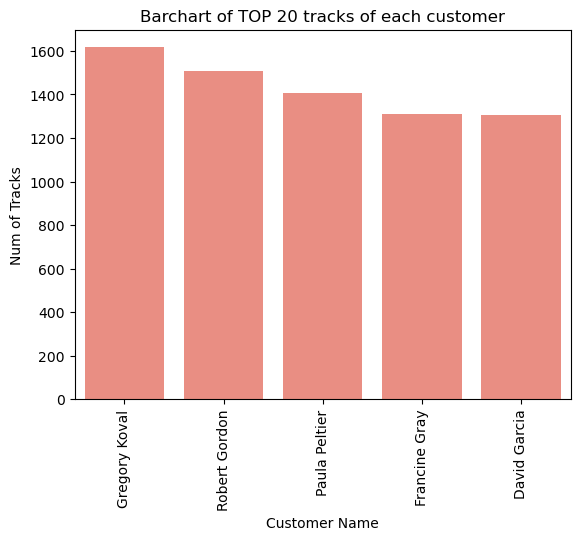

In [13]:
# Create a bar chart to show the top 20 tracks of customer
pd_result = result.toPandas()
sns.barplot(x = 'name', y = 'numTracks', data = pd_result[:5], color = 'salmon')
plt.title("Barchart of TOP 20 tracks of each customer")
plt.xlabel("Customer Name", rotation = 0)
plt.ylabel("Num of Tracks")
plt.xticks(rotation = 90)
plt.show()

In [18]:
# Calculate the how many tracks are using mobile device for each customer
mobile_result = spark.sql("SELECT custid, name, COUNT(DISTINCT trackid)\
                   as mobileCount FROM all_join WHERE mobile =0 GROUP BY custid,name ORDER BY mobileCount DESC")
mobile_result.show(5)

+------+-------------+-----------+
|custid|         name|mobileCount|
+------+-------------+-----------+
|     2|Paula Peltier|       1060|
|     0|Gregory Koval|       1054|
|     4| David Garcia|        920|
|     5|Matthew Perry|        889|
|     1|Robert Gordon|        864|
+------+-------------+-----------+
only showing top 5 rows



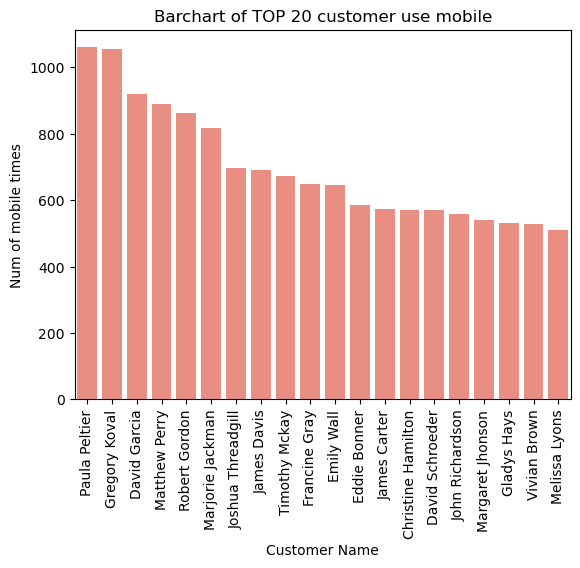

In [19]:
# Create a bar chart to show the top 20 customers who uses mobile a lot
pd_mobile_result = mobile_result.toPandas()
sns.barplot(x = 'name', y = 'mobileCount', data = pd_mobile_result[:20], color = 'salmon')
plt.title("Barchart of TOP 20 customer use mobile")
plt.xlabel("Customer Name", rotation = 0)
plt.ylabel("Num of mobile times")
plt.xticks(rotation = 90)
plt.show()

In [20]:
# Calculate how many customer listened for each song
songs_result = spark.sql("SELECT trackid, title, COUNT(DISTINCT custid) as numCust\
                         FROM all_join GROUP BY trackid, title ORDER BY numCust DESC")
songs_result.show(5)

+-------+--------------------+-------+
|trackid|               title|numCust|
+-------+--------------------+-------+
|      0|    Caught Up In You|   4190|
|      1|        Fantasy Girl|   3662|
|      2|     Hold On Loosely|   3390|
|      3|Hold On Loosely  ...|   3212|
|      4|   Art For Arts Sake|   2996|
+-------+--------------------+-------+
only showing top 5 rows



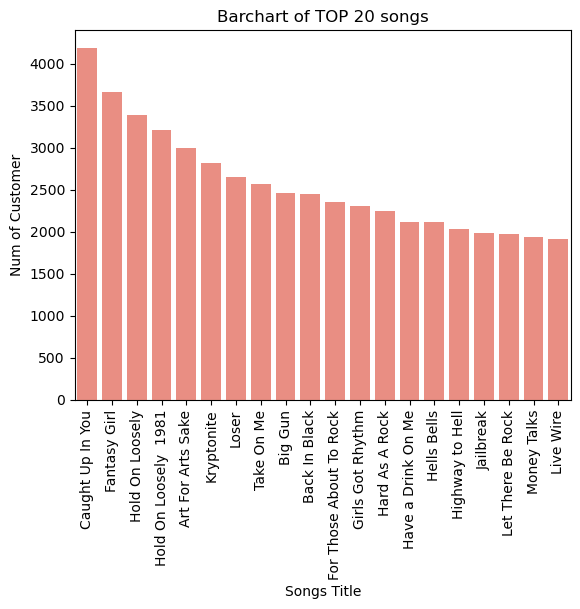

In [21]:
# Create a bar chart to show the top 20 songs have more customer listened
pd_song_result = songs_result.toPandas()
sns.barplot(x = 'title', y = 'numCust', data = pd_song_result[:20], color = 'salmon')
plt.title("Barchart of TOP 20 songs")
plt.xlabel("Songs Title", rotation = 0)
plt.ylabel("Num of Customer")
plt.xticks(rotation = 90)
plt.show()

In [15]:
final_table = spark.sql("SELECT custid, name, trackid, title, length , mobile, gender,\
                        split(datetime, ' ')[0] as date_l, split(datetime, ' ')[1] as time_l FROM all_join")
final_table = final_table.withColumn('hour_l', hour('time_l'))
final_table = final_table.withColumn('period_l', 
                                     when((final_table['hour_l'] >= 0) & (final_table['hour_l'] < 6), 'midnight')\
                                     .when((final_table['hour_l'] >= 6) & (final_table['hour_l'] < 12), 'morning')\
                                     .when((final_table['hour_l'] >= 12) & (final_table['hour_l'] < 18), 'afternoon')\
                                     .otherwise('evening'))
final_table = final_table.withColumn('week_l', weekofyear(to_date('date_l')))
final_table = final_table.withColumn('date_l', date_format('date_l', 'MM/dd/yy'))
final_table.show(5)
final_table.createOrReplaceTempView('final_table')

+------+--------------+-------+----------------+------+------+------+--------+--------+------+---------+------+
|custid|          name|trackid|           title|length|mobile|gender|  date_l|  time_l|hour_l| period_l|week_l|
+------+--------------+-------+----------------+------+------+------+--------+--------+------+---------+------+
|   148|     Ty Walker|    218|Cool The Engines|   307|     1|     1|11/04/14|13:17:00|    13|afternoon|    45|
|  1959| Douglas Burns|    920|            null|  null|     0|     0|11/06/14|12:41:00|    12|afternoon|    45|
|  4900|   Kathy Ramos|   1379|    SUPERSTITION|   182|     0|     0|11/21/14|13:58:00|    13|afternoon|    47|
|  1580|  Karen Bowker|     16|       Jailbreak|   160|     1|     1|10/09/14|07:37:00|     7|  morning|    41|
|   833|Jose Rodriques|    223|   Peace of Mind|   299|     0|     0|10/12/14|17:50:00|    17|afternoon|    41|
+------+--------------+-------+----------------+------+------+------+--------+--------+------+---------+

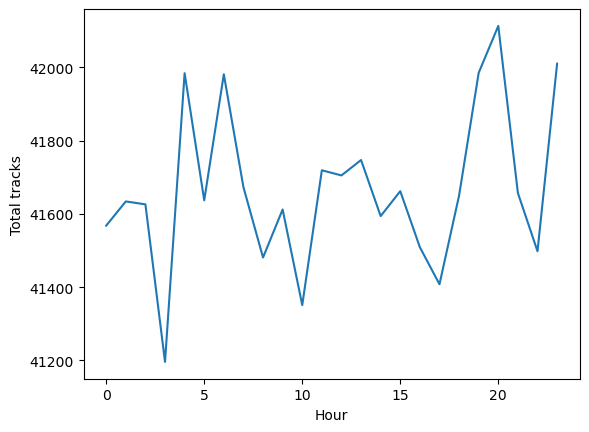

In [16]:
# Create a line plot to visualize the tracks within 24 hours
df_visual1 = spark.sql("SELECT CAST(hour_l AS INTEGER) AS hour_l, \
count(trackid) as totaltrack FROM final_table GROUP BY hour_l ORDER BY hour_l")
pd_visual1 = df_visual1.toPandas()
sns.lineplot(x = 'hour_l', y = 'totaltrack', data = pd_visual1)
plt.xlabel('Hour')
plt.ylabel('Total tracks')
plt.show()

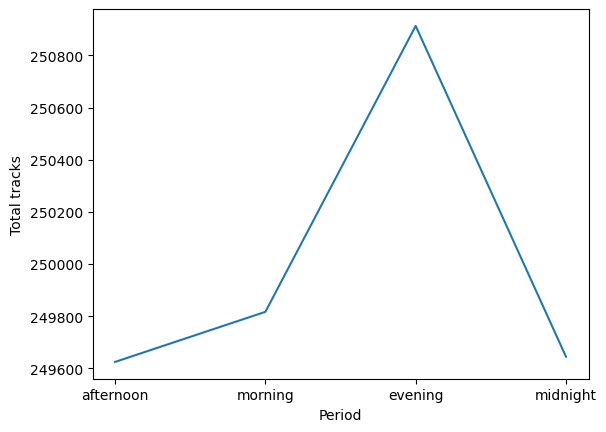

In [17]:
# Create a line plot to visualize the number of tracks within 4 periods
df_visual2 = spark.sql("SELECT period_l, \
count(trackid) as totaltrack FROM final_table GROUP BY period_l")
pd_visual2 = df_visual2.toPandas()
sns.lineplot(x = 'period_l', y = 'totaltrack', data = pd_visual2)
plt.xlabel('Period')
plt.ylabel('Total tracks')
plt.show()

### Section 2-2 Data Checking, Cleaning, and preprocessing

In [26]:
# fill the na value with average of the column
final_table = final_table.fillna({'length': 0})
# Checking is there any missing value for every columns
final_table.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in final_table.columns]
   ).show()
final_table.createOrReplaceTempView('final_table')

+------+----+-------+------+------+------+------+------+------+------+--------+------+
|custid|name|trackid| title|length|mobile|gender|date_l|time_l|hour_l|period_l|week_l|
+------+----+-------+------+------+------+------+------+------+------+--------+------+
|     0|   0|      0|180324|     0|     0|     0|     0|     0|     0|       0|     0|
+------+----+-------+------+------+------+------+------+------+------+--------+------+



We find out that only title and length column have missing value, but the main thing we cared about is the customer name, then we can just ignore those missing value. And we gonna split the data into train data and test data first, then we will calculate the rating scores seperately. Cause in the previous section, we select the data between week 40 and 51 as train data and week 52 and 53 as test data

In [35]:
train_data = spark.sql("SELECT * FROM final_table WHERE week_l <= 51 AND week_l >=40")
test_data = spark.sql("SELECT * FROM final_table WHERE week_l > 51")
train_data.createOrReplaceTempView('train_table')
test_data.createOrReplaceTempView('test_table')

### Section 2-3 Adding Features
In this section, we gonna percentile to create a kind of cummulative score to help to fit model.

In [36]:
# We create a new column called rating by calculate the percentile of the custid and trackid group
train_table = spark.sql("SELECT F.custid, F.trackid, B.rating \
FROM train_table AS F LEFT JOIN (SELECT custid, trackid, sum(case when length > 0 then 1 else 0 end) as rating \
FROM train_table GROUP BY custid, trackid) AS B ON (F.custid == B.custid AND F.trackid == B.trackid)")
test_table = spark.sql("SELECT F.custid, F.trackid, B.rating \
FROM test_table AS F LEFT JOIN (SELECT custid, trackid, sum(case when length > 0 then 1 else 0 end) as rating \
FROM test_table GROUP BY custid, trackid) AS B ON (F.custid == B.custid AND F.trackid == B.trackid)")
train_table.show(5)
train_table.createOrReplaceTempView('train_table')
test_table.show(5)
test_table.createOrReplaceTempView('test_table')

+------+-------+------+
|custid|trackid|rating|
+------+-------+------+
|  1225|   1097|     0|
|   353|    122|     0|
|  1102|   1198|     0|
|  1467|    824|     1|
|  1788|   1216|     1|
+------+-------+------+
only showing top 5 rows



+------+-------+------+
|custid|trackid|rating|
+------+-------+------+
|   116|      6|     1|
|   934|    718|     1|
|  1411|     45|     1|
|  1579|     98|     1|
|  3470|    134|     0|
+------+-------+------+
only showing top 5 rows



In [37]:
final_train_data = spark.sql("SELECT new.*, ROUND((rank() over (partition by custid \
order by num_cust desc)-1)*1.0/(count(trackid) over (partition by custid)-1), 4) \
as p_rank FROM (SELECT I.*, B.num_cust FROM \
train_table as I LEFT JOIN (SELECT trackid, count(distinct custid) AS num_cust FROM train_table GROUP BY trackid)\
AS B ON I.trackid == B.trackid) AS new")
final_test_data = spark.sql("SELECT new.*, ROUND((rank() over (partition by custid \
order by num_cust desc)-1)*1.0/(count(trackid) over (partition by custid)-1), 4) \
as p_rank FROM (SELECT I.*, B.num_cust FROM \
test_table as I LEFT JOIN (SELECT trackid, count(distinct custid) AS num_cust FROM test_table GROUP BY trackid)\
AS B ON I.trackid == B.trackid) AS new")
final_train_data.show(5)
final_test_data.show(5)

+------+-------+------+--------+------+
|custid|trackid|rating|num_cust|p_rank|
+------+-------+------+--------+------+
|     1|      0|    43|    4069|0.0000|
|     1|      0|    43|    4069|0.0000|
|     1|      0|    43|    4069|0.0000|
|     1|      0|    43|    4069|0.0000|
|     1|      0|    43|    4069|0.0000|
+------+-------+------+--------+------+
only showing top 5 rows



+------+-------+------+--------+------+
|custid|trackid|rating|num_cust|p_rank|
+------+-------+------+--------+------+
|     0|      0|     9|     755|0.0000|
|     0|      0|     9|     755|0.0000|
|     0|      0|     9|     755|0.0000|
|     0|      0|     9|     755|0.0000|
|     0|      0|     9|     755|0.0000|
+------+-------+------+--------+------+
only showing top 5 rows



## Section 3: Model Fitting

### Section 3-1-1 Random Forest Regressor without using implicit rating

In [47]:
# Set up the train and test data for regression model
reg_train_data = spark.sql("SELECT custid, trackid, length, mobile, gender, hour_l \
FROM final_table WHERE week_l <= 51 AND week_l >=40")
reg_test_data = spark.sql("SELECT custid, trackid, length, mobile, gender, hour_l \
FROM final_table WHERE week_l > 51")
# Define the feature column and the label column
input_features = ["custid", "length", "mobile", "gender", "hour_l"]
feature_col = VectorAssembler(inputCols=input_features, outputCol="features")

In [48]:
# Define the models
rf = RandomForestRegressor(labelCol='trackid',featuresCol='features', numTrees=20)
pipeline = Pipeline(stages=[rf])
model = pipeline.fit(feature_col.transform(reg_train_data))
predictions = model.transform(feature_col.transform(reg_test_data))
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="trackid", metricName="rmse")
reg_rmse = evaluator.evaluate(predictions)
#print("RMSE: %.3f" % rmse)

In [49]:
print('--'*11, "Summary  Table", "--"*11)
print('--'*30)
print("Root-mean-square error: " , reg_rmse)
print('--'*30)

---------------------- Summary  Table ----------------------
------------------------------------------------------------
Root-mean-square error:  485.64161955755935
------------------------------------------------------------


### Section 3-1-2 Random Forest Regressor with using implicit rating

In [44]:
# Define the feature column and the label column
input_features = ["custid", "rating"]
feature_reg = VectorAssembler(inputCols=input_features, outputCol="features")

In [45]:
# Define the models
rf2 = RandomForestRegressor(labelCol='trackid',featuresCol='features', numTrees=20)
pipeline2 = Pipeline(stages=[rf2])
model2 = pipeline2.fit(feature_reg.transform(train_table))
predictions2 = model2.transform(feature_reg.transform(test_table))
evaluator2 = RegressionEvaluator(predictionCol="prediction", labelCol="trackid", metricName="rmse")
reg_rmse2 = evaluator2.evaluate(predictions2)
#print("RMSE: %.3f" % rmse)

In [46]:
print('--'*11, "Summary  Table", "--"*11)
print('--'*30)
print("Root-mean-square error: " , reg_rmse2)
print('--'*30)

---------------------- Summary  Table ----------------------
------------------------------------------------------------
Root-mean-square error:  492.632401063172
------------------------------------------------------------


### Section 3-2 Recommendation Model from implicit rating

In [121]:
als = ALS(maxIter=5, regParam=0.01, userCol="custid", itemCol="trackid", ratingCol="rating")
paramGrid = ParamGridBuilder() \
    .addGrid(als.rank, [10, 20]) \
    .addGrid(als.regParam, [0.05, 0.1]) \
    .build()
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

cv = CrossValidator(estimator=als, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
cvModel = cv.fit(train_table)
predictions = cvModel.transform(test_table)
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = %f" % rmse)

Root-mean-square error = 1.620028


In [123]:
print('--'*11, "Summary  Table", "--"*11)
print('--'*30)
print("Root-mean-square error: " , rmse)
print("Best rank:", cvModel.bestModel.rank)
print("Best maxIter:", cvModel.bestModel._java_obj.parent().getMaxIter())
print("Best regParam:", cvModel.bestModel._java_obj.parent().getRegParam())
print('--'*30)

---------------------- Summary  Table ----------------------
------------------------------------------------------------
Root-mean-square error:  1.6200276861260547
Best rank: 20
Best maxIter: 5
Best regParam: 0.05
------------------------------------------------------------


In [125]:
best_als= ALS(maxIter=5, rank=20, regParam=0.05, userCol="custid", itemCol="trackid", ratingCol="rating", 
            coldStartStrategy="drop", implicitPrefs=True, nonnegative=False)
als_model = best_als.fit(train_table)

23/04/06 17:05:16 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/04/06 17:05:16 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


In [128]:
userPredict = als_model.recommendForAllUsers(10)
userPredict.show()

+------+--------------------+
|custid|     recommendations|
+------+--------------------+
|     1|[{193, 1.2897632}...|
|     3|[{182, 1.2418493}...|
|     6|[{182, 1.2035296}...|
|    12|[{31, 1.1878136},...|
|    13|[{35, 1.1938058},...|
|    16|[{35, 1.1926222},...|
|    20|[{17, 1.1647046},...|
|    22|[{31, 1.2463204},...|
|    26|[{30, 1.2055833},...|
|    27|[{22, 1.1992271},...|
|    28|[{31, 1.2367072},...|
|    31|[{31, 1.2072195},...|
|    34|[{26, 1.2027191},...|
|    40|[{11, 1.1621014},...|
|    44|[{13, 1.1842364},...|
|    47|[{35, 1.2097982},...|
|    48|[{15, 1.2481463},...|
|    52|[{33, 1.2131203},...|
|    53|[{24, 1.2248069},...|
|    54|[{9, 1.160826}, {...|
+------+--------------------+
only showing top 20 rows



### Section 3-2 Recommendation Model from explicit rating

In [29]:
explicit_table = spark.sql("SELECT custid, trackid,\
       CASE WHEN SUM(CASE WHEN length>=0 THEN 1 ELSE 0 END)<2 THEN 0\
            WHEN SUM(CASE WHEN length>=0 THEN 1 ELSE 0 END)<4 THEN 1\
            WHEN SUM(CASE WHEN length>=0 THEN 1 ELSE 0 END)<7 THEN 2\
            ELSE 3 END AS rating \
FROM final_table GROUP BY custid, trackid")
explicit_table.show()

+------+-------+------+
|custid|trackid|rating|
+------+-------+------+
|   148|    890|     0|
|  1342|    234|     0|
|  2366|    567|     0|
|  1645|     49|     0|
|   148|   1312|     0|
|   471|    412|     0|
|  1088|     14|     0|
|  2866|    430|     0|
|  4818|   1434|     0|
|  3749|    481|     0|
|  1580|    290|     0|
|  1645|     94|     0|
|  1342|     38|     1|
|   496|    149|     1|
|  3175|     75|     0|
|  1959|   1036|     0|
|   148|   1485|     1|
|   148|   1303|     0|
|  1088|   1587|     0|
|   148|    974|     1|
+------+-------+------+
only showing top 20 rows



In [36]:
rating_ex_train, rating_ex_test = explicit_table.randomSplit([0.8, 0.2],seed=40)
ex_als = ALS(maxIter=5, regParam=0.01, userCol="custid", itemCol="trackid", ratingCol="rating")
ex_paramGrid = ParamGridBuilder() \
    .addGrid(als.rank, [10, 20]) \
    .addGrid(als.regParam, [0.05, 0.1]) \
    .build()
ex_evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

ex_cv = CrossValidator(estimator=ex_als, estimatorParamMaps=ex_paramGrid, evaluator=ex_evaluator, numFolds=5)
ex_cvModel = ex_cv.fit(rating_ex_train)
predictions = ex_cvModel.transform(rating_ex_test)
ex_rmse = ex_evaluator.evaluate(predictions)
print("Root-mean-square error = %f" % ex_rmse)

23/04/06 23:33:53 WARN CacheManager: Asked to cache already cached data.
23/04/06 23:33:53 WARN CacheManager: Asked to cache already cached data.


Root-mean-square error = 0.336408


In [37]:
print('--'*11, "Summary  Table", "--"*11)
print('--'*30)
print("Root-mean-square error: " , ex_rmse)
print("Best rank:", ex_cvModel.bestModel.rank)
print("Best maxIter:", ex_cvModel.bestModel._java_obj.parent().getMaxIter())
print("Best regParam:", ex_cvModel.bestModel._java_obj.parent().getRegParam())
print('--'*30)

---------------------- Summary  Table ----------------------
------------------------------------------------------------
Root-mean-square error:  0.3364084196146312
Best rank: 10
Best maxIter: 5
Best regParam: 0.01
------------------------------------------------------------


In [40]:
best_ex_als= ALS(maxIter=5, rank=10, regParam=0.01, userCol="custid", itemCol="trackid", ratingCol="rating", 
            coldStartStrategy="drop", implicitPrefs=True, nonnegative=False)
ex_als_model = best_ex_als.fit(rating_ex_train)

In [41]:
userexPredict = ex_als_model.recommendForAllUsers(10)
userexPredict.show()

+------+--------------------+
|custid|     recommendations|
+------+--------------------+
|     1|[{76, 1.1636494},...|
|     3|[{34, 1.0643408},...|
|     6|[{20, 0.9961134},...|
|    12|[{20, 0.95577705}...|
|    13|[{8, 1.0419946}, ...|
|    16|[{7, 0.9656344}, ...|
|    20|[{8, 0.91753566},...|
|    22|[{6, 0.9248939}, ...|
|    26|[{5, 0.9536456}, ...|
|    27|[{6, 1.0747464}, ...|
|    28|[{7, 0.9537487}, ...|
|    31|[{9, 1.0733924}, ...|
|    34|[{6, 1.0813093}, ...|
|    40|[{6, 0.9959976}, ...|
|    44|[{6, 1.0376182}, ...|
|    47|[{6, 1.0277209}, ...|
|    48|[{5, 1.0316222}, ...|
|    52|[{7, 0.9687897}, ...|
|    53|[{4, 1.0331889}, ...|
|    54|[{6, 1.0881703}, ...|
+------+--------------------+
only showing top 20 rows

